## data loader

In [1]:

DATASET = "/home/sx/MPI_profile/lu.B.x/node_feature.csv"
TOPOLOGY = "/home/sx/MPI_profile/lu.B.x/graph_edge"


def data_load(): 
    data = pd.read_csv(DATASET, header=[0,1])
    data.columns.names = ['metric', 'host']
    tempm = data.stack()
    tempm = (tempm-tempm.mean())/(tempm.std())
    metric = tempm.unstack().swaplevel('metric','host',axis=1).stack().unstack()


    edge_data = pd.read_csv(TOPOLOGY, header=0)
    # edge_data = edge_data.groupby(['ts_id','src', 'dst']).agg({'commsize': 'sum'}).reset_index()
    edge_data = edge_data.groupby(['src', 'dst']).agg({'commsize': 'sum'}).reset_index()

    edge_index = edge_data[['src', 'dst']].values.T.tolist()
    edge_weight = edge_data['commsize'].values.tolist()

    # print("metric:")
    # print(metric)

    print("Edge Index:")
    print(edge_index)

    # print("Edge Weight:")
    # print(edge_weight)

    return metric, edge_index


## 加载数据与模型

In [2]:
from graphlstm_vae_ad import GraphLSTM_VAE_AD
import pandas as pd
import numpy as np

metric, edge_index = data_load()



Edge Index:
[[0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 4, 4, 5, 5, 5, 6, 6, 6, 7, 7], [1, 4, 0, 2, 5, 1, 3, 6, 2, 7, 0, 5, 1, 4, 6, 2, 5, 7, 3, 6]]


In [26]:
print(metric)

host      node_0                                                              \
metric  vector_0  vector_1 vector_10 vector_11 vector_12 vector_13 vector_14   
0      -2.469952  1.087437  0.380074  0.267648  2.373910 -0.205990 -3.865601   
1      -0.293625  0.512320 -0.701273 -0.688950 -0.793420  0.916968 -0.294596   
2       1.835981 -0.552679 -1.883275 -0.443511 -0.745906  1.610549  1.253340   
3      -0.519725  0.322472  0.922007 -1.077442 -0.755303  0.605368  0.191932   
4      -0.796766  0.444147  1.203752 -1.188799 -0.769085  0.475898  0.054559   
...          ...       ...       ...       ...       ...       ...       ...   
2671   -0.884636  0.454233  1.385753 -1.187749 -0.772892  0.457335  0.045648   
2672   -0.899099  0.470282  1.361911 -1.222845 -0.782346  0.437226  0.022111   
2673   -0.388659  0.355310  0.894476 -1.147184 -0.858689  0.712579  0.280943   
2674    1.019473 -0.317894 -1.256490 -0.474199 -0.854200  0.918265  0.313609   
2675   -4.541779  3.741525  1.057087 -3.

In [27]:
# model = GraphLSTM_VAE_AD(sequence_length=120, gpu=1)
model = GraphLSTM_VAE_AD(sequence_length=30, gpu=1, hidden_dim=5, batch_size=32, lr=1e-3, num_epochs=100)

## 训练模型

Epoch [100/100], Iter [40/57], total_loss: 1366.0139, recon_loss: 1337.8191, kl_loss: 28.1948
valid_loss: [4102.499766031901, 3834.8280131022134, 3621.5660502115884, 3694.9249267578125, 3055.913289388021, 2754.109202067057, 2600.0155131022134, 2503.7059631347656, 2418.7781778971353, 2361.880574544271, 2299.4722900390625, 2258.9213053385415, 2191.7307739257812, 2157.348648071289, 2137.9150899251304, 2120.7703908284507, 2104.87814839681, 2021.6168314615886, 2000.1913655598958, 1961.4056091308594, 1996.2952982584636, 1978.1180826822917, 1881.2728322347004, 1852.049524943034, 1837.6226654052734, 1852.6824595133464, 1808.657953898112, 1796.772928873698, 1766.5020294189453, 1768.9968872070312, 1763.0542449951172, 1722.9919331868489, 1716.0728454589844, 1710.0662333170574, 1686.4568430582683, 1678.1888224283855, 1695.6260833740234, 1637.1402689615886, 1616.0889994303386, 1731.4676564534504, 1600.2991943359375, 1586.6416269938152, 1594.4325663248699, 1554.568598429362, 1536.7738291422527, 1521

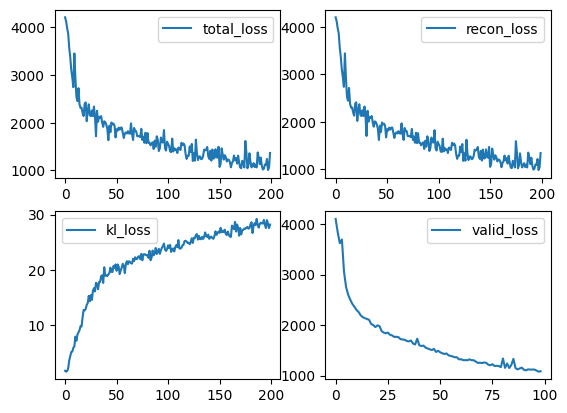

100%|██████████| 24/24 [00:14<00:00,  1.66it/s]


In [28]:
model.fit(metric, 8, edge_index)

In [5]:
model.load(8, metric.shape[1])

In [6]:
scores_sum = []
scores_max = []
outputs = []
scores_sum, scores_max, outputs = model.predict(metric, 8, edge_index, 20)

100%|██████████| 1198/1198 [2:54:38<00:00,  8.75s/it] 


In [26]:
mylog = open('output.txt', mode = 'a',encoding='utf-8')
for i in range(len(outputs)):
    print(outputs[i], file=mylog)
mylog.close()
# df_outputs = pd.DataFrame(data=outputs)
# df_outputs.to_csv('outputs.csv')
# print(outputs)

In [28]:
mylog = open('scores_max.txt', mode = 'a',encoding='utf-8')
for i in range(len(scores_max)):
    print(scores_max[i], file=mylog)
mylog.close()